In [16]:
# Importing the pandas library
import pandas as pd

# Creating a dictionary to hold file names and their corresponding DataFrames
files = ['holidays_events.csv', 'oil.csv', 'stores.csv', 'test.csv', 'train.csv', 'transactions.csv']
dataframes = {}

# Reading each CSV file into a DataFrame and storing it in the dictionary
for file in files:
    try:
        # Reading the CSV file
        df = pd.read_csv(f'data/{file}')
        
        # Storing the DataFrame in the dictionary
        dataframes[file] = df
        
        # Printing a snippet of the DataFrame
        print(f"Snippet of {file}:")
        print(df.head())  # Print the first 5 rows of the DataFrame
        print("\n" + "="*50 + "\n")  # Print a separator between snippets
    except FileNotFoundError:
        print(f"File {file} not found in the data folder.")
    except Exception as e:
        print(f"An error occurred while processing {file}: {e}")

Snippet of holidays_events.csv:
         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  


Snippet of oil.csv:
         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20


Snippet of stores.csv:
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito             

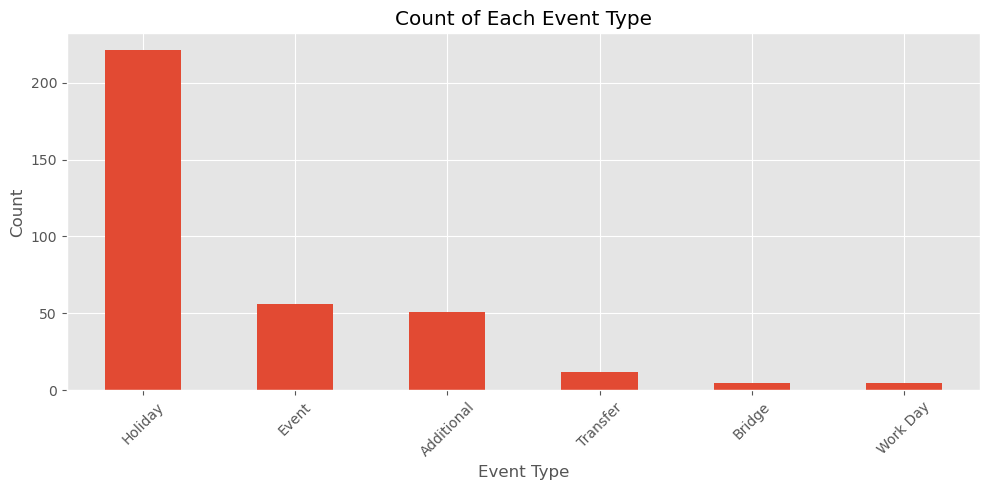

<Figure size 1000x500 with 0 Axes>

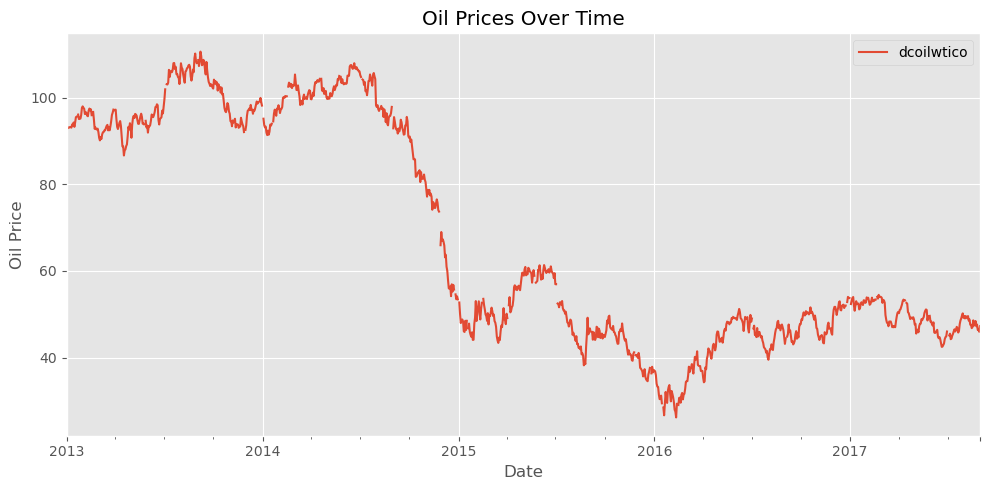

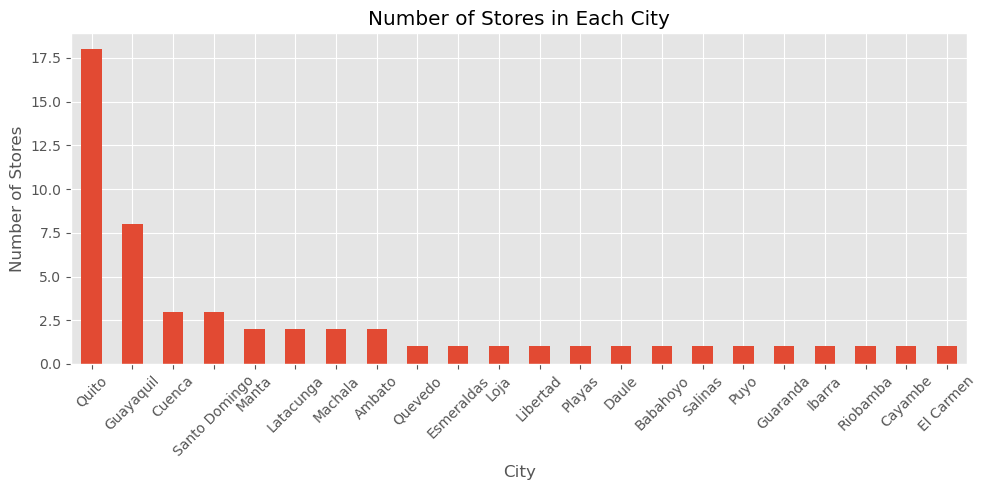

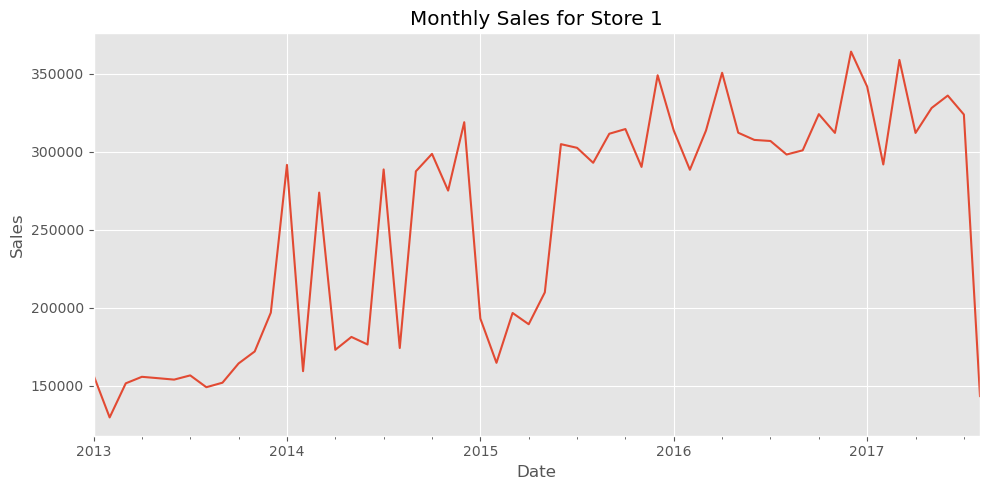

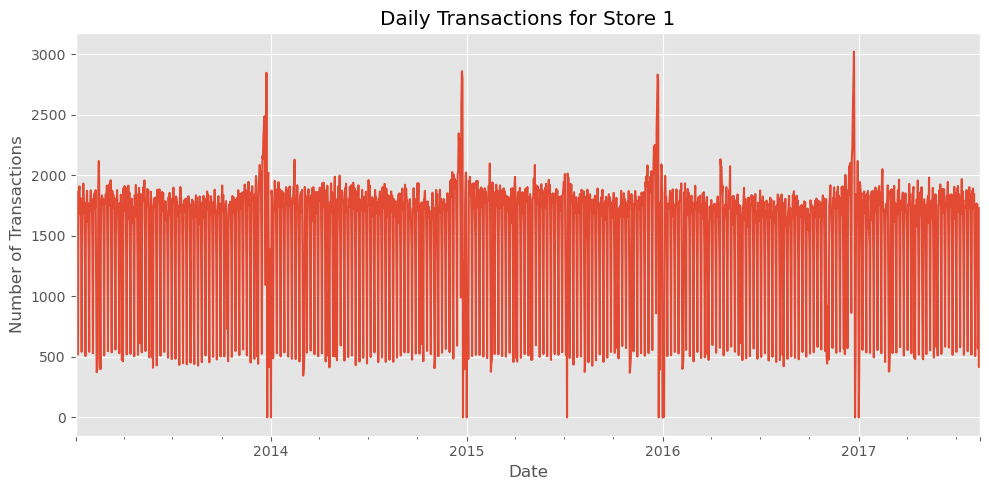

In [17]:
import matplotlib.pyplot as plt

# Convert the 'date' columns to datetime for relevant dataframes
dataframes['holidays_events.csv']['date'] = pd.to_datetime(dataframes['holidays_events.csv']['date'])
dataframes['oil.csv']['date'] = pd.to_datetime(dataframes['oil.csv']['date'])
dataframes['train.csv']['date'] = pd.to_datetime(dataframes['train.csv']['date'])
dataframes['transactions.csv']['date'] = pd.to_datetime(dataframes['transactions.csv']['date'])

# Set style
plt.style.use('ggplot')

# 1. Holidays and Events
plt.figure(figsize=(10,5))
dataframes['holidays_events.csv']['type'].value_counts().plot(kind='bar')
plt.title('Count of Each Event Type')
plt.ylabel('Count')
plt.xlabel('Event Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Oil Prices
plt.figure(figsize=(10,5))
dataframes['oil.csv'].set_index('date').plot(figsize=(10,5))
plt.title('Oil Prices Over Time')
plt.ylabel('Oil Price')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# 3. Store Distribution by City
plt.figure(figsize=(10,5))
dataframes['stores.csv']['city'].value_counts().plot(kind='bar')
plt.title('Number of Stores in Each City')
plt.ylabel('Number of Stores')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Daily Sales (for store 1 as an example)
store_1_sales = dataframes['train.csv'][dataframes['train.csv']['store_nbr'] == 1]
store_1_sales.set_index('date').groupby(pd.Grouper(freq='M')).sum()['sales'].plot(figsize=(10,5))
plt.title('Monthly Sales for Store 1')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# 5. Daily Transactions (for store 1 as an example)
store_1_trans = dataframes['transactions.csv'][dataframes['transactions.csv']['store_nbr'] == 1]
store_1_trans.set_index('date').groupby(pd.Grouper(freq='D')).sum()['transactions'].plot(figsize=(10,5))
plt.title('Daily Transactions for Store 1')
plt.ylabel('Number of Transactions')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


In [22]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Assuming data is loaded as per your previous code
train = dataframes['train.csv']
oil = dataframes['oil.csv']
holidays_events = dataframes['holidays_events.csv']
stores = dataframes['stores.csv']

# Filter train data for a single store
store_1_sales = train[train['store_nbr'] == 1].copy()

# Feature Engineering

# Lag and rolling mean features
for lag in [1, 3, 7]:
    store_1_sales[f'lag_{lag}'] = store_1_sales['sales'].shift(lag)
store_1_sales['rolling_mean_7'] = store_1_sales['sales'].rolling(window=7).mean()

# Merge with oil data
store_1_sales = pd.merge(store_1_sales, oil, on='date', how='left')

# Merge with stores metadata
store_1_sales = pd.merge(store_1_sales, stores, on='store_nbr', how='left')

# Consider Holidays
store_1_sales['is_holiday'] = store_1_sales['date'].isin(holidays_events['date']).astype(int)
store_1_sales['is_transfer'] = store_1_sales['date'].isin(holidays_events[holidays_events['type'] == 'Transfer']['date']).astype(int)
store_1_sales['is_bridge'] = store_1_sales['date'].isin(holidays_events[holidays_events['type'] == 'Bridge']['date']).astype(int)

# Pay Days
store_1_sales['is_pay_day'] = store_1_sales['date'].apply(lambda x: 1 if (x.day == 15) or (x.day == x.days_in_month) else 0)

# Earthquake Effect
start_date = pd.to_datetime('2016-04-16')
end_date = start_date + pd.DateOffset(weeks=6)  # Approx 6 weeks after earthquake
store_1_sales['post_earthquake'] = store_1_sales['date'].apply(lambda x: 1 if start_date <= pd.to_datetime(x) <= end_date else 0)

# Temporal Validation

# Last 60 days for validation
train_data = store_1_sales[:-60]
val_data = store_1_sales[-60:]

# Features and Target Variables
X_train = train_data.drop(columns=['id', 'date', 'store_nbr', 'sales', 'city', 'state', 'type'])
y_train = train_data['sales']
X_val = val_data.drop(columns=['id', 'date', 'store_nbr', 'sales', 'city', 'state', 'type'])
y_val = val_data['sales']

# Splitting data into numeric and categorical
X_train_numeric = X_train.select_dtypes(exclude=['object'])
X_train_categorical = X_train.select_dtypes(include=['object'])

X_val_numeric = X_val.select_dtypes(exclude=['object'])
X_val_categorical = X_val.select_dtypes(include=['object'])

# Imputation for numeric data
numeric_imputer = SimpleImputer(strategy='mean')
X_train_numeric_imputed = pd.DataFrame(numeric_imputer.fit_transform(X_train_numeric), columns=X_train_numeric.columns)
X_val_numeric_imputed = pd.DataFrame(numeric_imputer.transform(X_val_numeric), columns=X_val_numeric.columns)

# Imputation for categorical data
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train_categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_train_categorical), columns=X_train_categorical.columns)
X_val_categorical_imputed = pd.DataFrame(categorical_imputer.transform(X_val_categorical), columns=X_val_categorical.columns)

# One-Hot Encoding categorical data
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train_categorical_imputed))
X_val_encoded = pd.DataFrame(encoder.transform(X_val_categorical_imputed))

# Combining numeric and encoded categorical data
X_train_final = pd.concat([X_train_numeric_imputed, X_train_encoded], axis=1)
X_val_final = pd.concat([X_val_numeric_imputed, X_val_encoded], axis=1)

# Ensure all column names are strings before feeding to the model
X_train_final.columns = X_train_final.columns.astype(str)
X_val_final.columns = X_val_final.columns.astype(str)

# Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_final, y_train)
y_pred = model.predict(X_val_final)

# Measure RMSE
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


/Users/gleb/miniconda3/envs/grocery_store_ml/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Root Mean Squared Error (RMSE): 50.64


In [18]:
# 1. Relative to the Scale of the Dependent Variable
mean_sales = y_val.mean()
max_sales = y_val.max()
min_sales = y_val.min()

print(f"Mean Sales: {mean_sales:.2f}")
print(f"Min Sales: {min_sales:.2f}")
print(f"Max Sales: {max_sales:.2f}")
print(f"RMSE as a percentage of mean sales: {rmse/mean_sales*100:.2f}%")
print(f"Range of Sales: {max_sales - min_sales:.2f}")

# 2. Percentage of Accuracy
accuracy = (1 - (rmse/mean_sales)) * 100
print(f"Percentage Accuracy: {accuracy:.2f}%")

# 3. Compare with a Simple Model (Naive Forecasting)
y_pred_naive = y_train.shift(1).fillna(method='bfill')  # fill the first value with the second
rmse_naive = mean_squared_error(y_val, y_pred_naive[:len(y_val)], squared=False)
print(f"RMSE of Naive Forecasting: {rmse_naive:.2f}")


Mean Sales: 295.05
Min Sales: 0.00
Max Sales: 2611.76
RMSE as a percentage of mean sales: 14.42%
Range of Sales: 2611.76
Percentage Accuracy: 85.58%
RMSE of Naive Forecasting: 788.83
